# Oligo Design for RegSeq Style Experiments

© 2023 Tom Röschinger. This work is licensed under a <a href="https://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution License CC-BY 4.0</a>. All code contained herein is licensed under an <a href="https://opensource.org/licenses/MIT">MIT license</a>

***

In RegSeq we use mutagenized variants of promoters to identify binding sites for regulatory components. These promoter variants are designed computationally and then synthesized. In this notebook we explain how the oligo design works and design a test set.

In [3]:
# Import packages
using wgregseq, FASTX, DataFrames, CSV, BioSequences, CairoMakie

# Set plotting style
wgregseq.plotting_style.default_makie!()

┌ Warning: SIMD capacity not detected by ScanByte, using scalar fallback
└ @ ScanByte /Users/tomroeschinger/.julia/packages/ScanByte/eOQJf/src/ScanByte.jl:11


## Data Import

First we import the wildtype sequence for *E. coli* K12 MG1655. 

In [4]:
# Import genome for E.coli K12 MG1655
re = open(FASTA.Reader, "../data/ecocyc/mg1655_genome.fasta")

# Read out sequence
wt_sequence = [sequence(record) for record in re][1]

4641652nt DNA Sequence:
AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGT…AATATCACCAAATAAAAAACGCCTTAGTAAGTATTTTTC

Next we import the list of genes that we want to create promoter variants for. Once the genes are imported, we group them into certain classes. These classes can be used to design certain primer sets that allow to amplify only a certain group of genes from the entire pool. The classes were annotated manually when we chose the genes that would be studied in this experiment.

In [5]:
# Import gene list to generate sequences for
gene_table = CSV.read(
    "../data/100_genes.csv", 
    DataFrames.DataFrame, 
    delim=",",
    comment="#",
    missingstring="none",
)

# Give IDs to groups 
group_dict = Dict{String, Int64}(filter(x -> occursin("Antibiotic/toxin", x), gene_table.group) .=> 1)
group_dict["Gold Standard"] = 2
group_dict["Heinemann dataset"] = 3
group_dict["uncharacterized protein"] = 4
group_dict["Heinemann dataset uncharacterized"] = 7
group_dict["YmfT_modulon"] = 5
group_dict["YgeV_modulon"] = 6

# Give give IDs to genes
groups = zeros(nrow(gene_table))
for i in 1:nrow(gene_table)
    if gene_table[i, "group"] in keys(group_dict)
        groups[i] = group_dict[gene_table[i, "group"]]
    else
        groups[i] = 8
    end
end

# Add IDs to table
insertcols!(gene_table, 4, :group_ID => groups)

# Print number of genes per group
println(combine(groupby(gene_table, "group"), nrow=>Symbol("Number of Genes")))

14×2 DataFrame
 Row │ group                              Number of Genes 
     │ String                             Int64           
─────┼────────────────────────────────────────────────────
   1 │ Gold Standard                                   18
   2 │ Antibiotic/toxin                                19
   3 │ Inc-4 (x) - stress                               1
   4 │ Inc-4 (y) - stress                               1
   5 │ Inc-4 (z) - stress                               1
   6 │ Inc-1 (x)                                        1
   7 │ Inc-1 (y)                                        1
   8 │ Inc-1 (z1)                                       1
   9 │ Inc-1 (z2)                                       1
  10 │ Heinemann dataset                                9
  11 │ Heinemann dataset uncharacterized               11
  12 │ uncharacterized protein                         13
  13 │ YmfT_modulon                                    16
  14 │ YgeV_modulon                                   

Next we import the promoters we exported from the Ecocyc database previously (check out notebook `database_query.ipynb`). The table we import contains the promoter name, the genes that are transcribed from this promoter, the location of the promoter in the genome, and the direction at which transcription takes place.

In [6]:
# Import promoter list and infer types that can be infered automatically
promoter_list = CSV.read(
    "../data/promoter_list_ecocyc.csv",
    DataFrames.DataFrame, 
    types=Dict(
        "promoter"=>String,
        "tss"=>Float64,
        "direction"=>String
    )
)
first(promoter_list, 5)

,promoter,genes,gene_position,direction
,String,String,String,String?
1,uspAp1,"[""uspA""]",[3.640111e6],+
2,glnBp3,"[""glnB""]",[2.687408e6],-
3,mazEp2,"[""mazG"", ""mazE"", ""mazF""]","[2.910685e6, 2.911339e6, 2.911091e6]",-
4,ffhp,"[""ffh""]",[2.747795e6],-
5,blrp,"[""blr""]",[1.704551e6],+


There is a also a list of genes that are transcribed together, but do not have a transcription start site annotated with them. We use a computational model to predict possible transcription start sites for these genes. For details, check out this [paper](https://www.nature.com/articles/s41467-022-32829-5).

In [7]:
operons_without_promoters = CSV.read(
    "../data/operons_without_promoters.csv", 
    DataFrames.DataFrame, 
    types=Dict(
        "direction"=>String
    )
)

first(operons_without_promoters, 5)

,genes,direction,gene_position
,String,String,String
1,"[""tfaE"", ""stfE""]",-,"[1.209119e6, 1.209655e6]"
2,"[""yabR""]",-,[85511.0]
3,"[""trmB"", ""yggL""]",-,"[3.102852e6, 3.102133e6]"
4,"[""rluB""]",+,[1.326852e6]
5,"[""insH2""]",-,[575717.0]


Importing dataframes with columns that contain arrays as entries leads to them being imported as strings (the column is a list of strings: `Vector{String}`). Therefore we need to do some correction and change the types of these entries, such that we actually have a list at each entry, and not a string. For example, the column for gene positions should have type `Vector{Vector{Int64}}`, which means that the column is a list, where each entry is a list of Integers.

In [8]:
typeof(promoter_list.gene_position) 

Vector{String} (alias for Array{String, 1})

To be able to work with these columns we need to transform the types back to their correct type. We wrote some extensions to the `parse` function in Julia's `Base`, which does exactly that. Make sure that the `wgregseq` package is imported, such that these functions are available for use.

In [9]:
# Replace columns by nicer types
promoter_list.genes = parse.(Vector{String}, promoter_list.genes)
promoter_list.gene_position = parse.(Vector{Float64}, promoter_list.gene_position)
promoter_list.evidence = parse.(Vector{String}, promoter_list.evidence)

operons_without_promoters.genes = parse.(Vector{String}, operons_without_promoters.genes)
operons_without_promoters.gene_position = parse.(Vector{Float64}, operons_without_promoters.gene_position)

typeof(promoter_list.gene_position)  # Vector{Vector{Float64}}

Vector{Vector{Float64}} (alias for Array{Array{Float64, 1}, 1})

Many genes have multiple synonyms. Therefore, we need to check that each gene is listed with the correct name that matches with the gene names in our database. We have a table with all genes that contains entries for all synonyms.

In [10]:
# Some genes may have the wrong synomym
all_gene_list = CSV.read(
    "../data/all_genes_table.csv", 
    DataFrame, 
    types=Dict(
        "ID"=>String,
        "gene"=>String,
        "gene_position"=>Float64,
        "direction"=>String
    )
)

# Get the correct types
all_gene_list.synonyms = parse.(Vector{String}, all_gene_list.synonyms)
all_gene_list.transcription_units = parse.(Vector{String}, all_gene_list.transcription_units);

Replace gene names with synomyms if necessary.

In [11]:
# Replace gene names if they are synonyms
for i in 1:nrow(gene_table)
    name = String(gene_table[i, "name"])
    if name ∉ all_gene_list.gene
        syn = all_gene_list[map(x -> name in x, all_gene_list.synonyms), :gene][1]
        gene_table[i, "name"] = syn
    end
end

gene_group_ID_dict = Dict(gene_table.name .=> gene_table.group_ID);

## Find Transcription Start Sites

Now we need to find the promoters and transcription start sites for the genes we want to study in this experiment. Therefore we look into the table of promoters `promoter_list` for every gene in our gene table. If we find an entry for a promoter, we save the entry for that promoter, including the transcription start site.

In [1]:
# Dataframe to store promoters
df_list = DataFrame[]
# List of genes without promoters
genes_no_tss = []

# Iterate through genes
for gene in gene_table.name
    _df = promoter_list[
        map(
            x -> gene in x, 
            promoter_list.genes
        ), 
        [:tss, :direction, :gene_position, :genes, :promoter, :evidence]
    ]

    if nrow(_df) > 0
        push!(df_list, _df)
    else
        push!(genes_no_tss, gene)
    end
end

# Concat
df = vcat(df_list...) |> unique
first(df, 5)

LoadError: UndefVarError: DataFrame not defined

Now we try to identify the operons for genes that do not have a transcription start sites. We will use that information to find the best candidates for transcription start sites later on.

In [ ]:
df_no_prom = DataFrame()
for gene in genes_no_tss
    append!(df_no_prom, operons_without_promoters[map(x -> gene in x, operons_without_promoters.genes), :])
end
if nrow(df_no_prom) > 0
    unique!(df_no_prom)
end

first(df_no_prom, 5)

,genes,direction,gene_position
,Array…,String,Array…
1,"[""dicA""]",+,[1.64793e6]
2,"[""yagB"", ""insX"", ""yagA""]",-,"[280735.0, 280362.0, 281983.0]"
3,"[""yjjJ""]",+,[4.62177e6]
4,"[""tmaR""]",-,[2.07936e6]
5,"[""yjbJ""]",+,[4.25924e6]


First, we use the data set from Urtecho et al., 2020, in which every part of the E.coli genome was investigated for transcriptional activity. What that means is that a part of the genome was cloned in front of a reporter gene and the activity was measured by counting the number of transcripts for each genomic sequence. Then, these sequences were classified into active and inactive sites.

In [ ]:
# import Urtecho data
urtecho_tss = CSV.read(
    "../data/urtecho_2020/tss_operon_regulation.txt", 
    DataFrame 
)

first(urtecho_tss, 5)

,tss_name,tss_strand,tss_position,prom_expression,active
,String,String1,Int64,Float64,String15
1,TSS_11125_storz_regulondb,+,2945404,53.2139,active
2,TSS_16748_storz,+,4275469,0.748653,inactive
3,TSS_16918_storz,-,4339955,0.653776,inactive
4,TSS_9847_regulondb,+,2619175,0.801252,inactive
5,TSS_14431_storz,+,3718711,0.703256,inactive


Now we are going to check if we can identify any active transcription start sites for the genes that we did not find any promoters for yet.

In [2]:
# Check if gene is part of operon
function occursin_operon(gene, operon)
    split_operon = split(operon, "-")
    a, b = gene[1:3], gene[4]
    return prod(occursin.(a, split_operon) .* occursin.(b, split_operon))
end

# Find operon in Urtecho data
df_tss_urtecho = DataFrame()

# Make array to store indeces of genes to be removed from list
delete_index_list = Int64[]
for i in 1:nrow(df_no_prom)
    # Get row data
    genes = df_no_prom[i, "genes"]
    gene_position = df_no_prom[i, "gene_position"]
    for gene in genes
        # Check for each gene if part of an identied operon
        operons = filter(x -> prod(occursin_operon.(gene, x)), urtecho_tss.operon)
        
        # Sanity check
        if (operons |> unique |> length) > 1
            throw(ErrorException("More than one operon for genes: $(genes)"))
            
        # Of no operon identified, skip
        elseif  (operons |> unique |> length) == 0

        # If one operon is identified, check for active site
        else
            operon = unique(operons)[1]
            temp = urtecho_tss[(urtecho_tss.operon .== operon) .& ((urtecho_tss.active .== "active")), :]
            # If active site is found, add to dataframeb
            if nrow(temp) != 0
                insertcols!(temp, 2, :genes => fill(genes, nrow(temp)))
                insertcols!(temp, 2, :gene_position => fill(gene_position, nrow(temp)))
                insertcols!(temp, 2, :evidence => fill(["EXP"], nrow(temp)))
                rename!(temp, "tss_strand" => "direction", "tss_position"=> "tss", "tss_name"=>"promoter")
                append!(df_tss_urtecho, temp)
                push!(delete_index_list, i)
            end
        end
    end
end

# Add found promoters to list
if nrow(df_tss_urtecho) > 0
    append!(df, df_tss_urtecho[:, ["genes", "tss", "direction", "gene_position", "promoter", "evidence"]])
end

# Remove genes with identified promoters from list of genes without promoters
df_no_prom = df_no_prom[Not(delete_index_list), :];

LoadError: UndefVarError: DataFrame not defined

Some genes do not have a transcription start site annotated with them. To find a promoter sequence for such genes, we use the model from [La Fleur et al 2022](https://www.biorxiv.org/content/10.1101/2021.09.01.458561v1), which predicts promoter strengths for any DNA sequence. We look for the strongest predicted promoter in the vacinity of the coding region of a gene. First we demonstrate how we use the promoter prediction. Here, we generate a random 160 bp sequence and use the promoter calculator on that sequence.

┌ Warning: Could not find font /Users/tomroschinger/.julia/packages/Makie/vwpRo/assets/fonts/NotoSans-Regular.tff, using Dejavu Sans
└ @ Makie /Users/tomroschinger/.julia/packages/Makie/vwpRo/src/conversions.jl:946


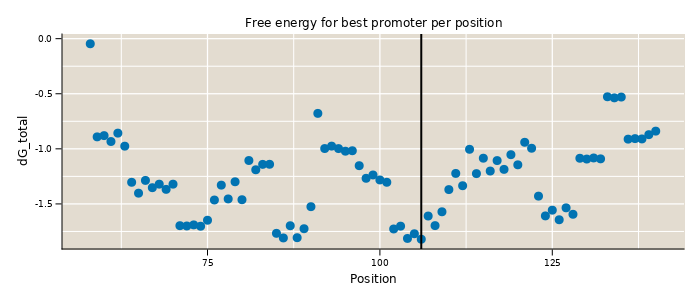

In [30]:
# Create a random sequence
rand_seq = rand([DNA_A, DNA_C, DNA_G, DNA_T], 160) |> LongDNA{4}

# Initiate the promoter calculator
p = wgregseq.promoter_finder.Promoter_Calculator()

# Find best possible promoter per position
r = p(rand_seq)["Forward_Predictions_per_TSS"]

# Extract TSS and free energy
_x = [(key, r[key]["dG_total"]) for key in keys(r) |> collect]
opt_prom = argmin([x[2] for x in _x])

# Plot results
fig = Figure(resolution=(700, 300))
ax = Axis(fig[1, 1])
ax.xlabel = "Position"
ax.ylabel = "dG_total"
ax.title = "Free energy for best promoter per position"
scatter!(ax, _x)

# Mark best promoter
vlines!(ax, _x[opt_prom][1], color="black", linewidth=2)

# Show plot
fig

Now we can use the promoter calculator on every gene that does not have a promoter annotated. We have to choose a region upstream of each gene's coding region to look for a promoter. Hence, we look for the distance of every transcription site that we have identified to the coding region of the first gene in the transcription unit.

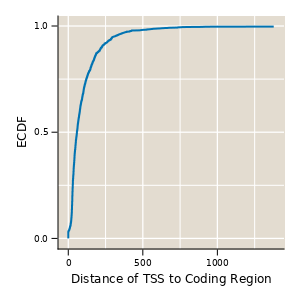

In [31]:
# Find absolute distance of every gene in TU to TSS
y = [abs.(promoter_list[i, "gene_position"] .- promoter_list[i, "tss"]) for i in 1:nrow(promoter_list)]

# Find minimum distance
y = minimum.(y)

# Make figure
fig = Figure(resolution=(300, 300))
ax = Axis(fig[1, 1])
lines!(ax, sort(y), 0:1/length(y):1-1/length(y), linewidth=2)
ax.xlabel = "Distance of TSS to Coding Region"
ax.ylabel = "ECDF"

# Show figure
save("../figures/tss_CR_distance.pdf", fig)
fig

We find that most transcription start sites are within 500 base pairs of the coding region. We choose this range as region to search for the best predicted promoter for genes without previously identified transcription start sites.

In [103]:
# Initiate promoter calculator
p = wgregseq.promoter_finder.Promoter_Calculator()

# Initiate arrays to store tss and gene name
tss_list = Int64[]
name_list = String[]

# Iterate through dataframe
for i in 1:nrow(df_no_prom)
    # Check which strand the gene is on
    if df_no_prom[i, "direction"] == "+"
        # Find beginning of coding region
        ind = Int64(minimum(df_no_prom[i, "gene_position"]))
        
        # Extract genome sequence 
        sequence = wt_sequence[ind-500:ind]
        
        # Apply promoter calculator
        r = p(sequence)["Forward_Predictions_per_TSS"]
        
        # Take total free energy
        _x = [(key, r[key]["dG_total"]) for key in keys(r) |> collect]
        
        # Find position of best tss
        tss = _x[argmin([x[2] for x in _x])][1] + ind - 500
    else
        # Find beginning of coding region
        ind = Int64(maximum(df_no_prom[i, "gene_position"]))
        
        # Extract genome sequence 
        sequence = wt_sequence[ind:ind+500]
        
        # Apply promoter calculator
        r = p(sequence)["Reverse_Predictions_per_TSS"]
        
         # Take total free energy
        _x = [(key, r[key]["dG_total"]) for key in keys(r) |> collect]
        
        # Find position of best tss
        tss = _x[argmin([x[2] for x in _x])][1] + ind
    end
    # Add tss and name to arrays
    push!(tss_list, tss)
    push!(name_list, join(df_no_prom[i, "genes"], "_") * "_predicted")
end

if nrow(df_no_prom)  >0 
    # Add start sites to genes 
    insertcols!(df_no_prom, 2, :tss =>tss_list)
    
    # Add information that they are predicted
    insertcols!(df_no_prom, 5, :promoter =>name_list)
    insertcols!(df_no_prom, 5, :evidence =>fill(["COMP"], nrow(df_no_prom)))
    
    # Add promoters to list
    append!(df, df_no_prom)
end

LoadError: ArgumentError: Column tss is already present in the data frame which is not allowed when `makeunique=true`

Now we have one transcription start site for every promoter in our list. Next, we generate the mutated sequences. 

In [142]:
# Create a random sequence of length 20
rand_seq = rand([DNA_A, DNA_C, DNA_G, DNA_T], 20) |> LongDNA{4}

# Create 1500 mutated sequences with mutation rate 0.1
seqs = wgregseq.design.mutations_rand(rand_seq, 0.1, 1500)

# First sequence is wild type
wt_seq = seqs[1]

# Next 1500 are mutated
mut_seqs = seqs[2:end]

# Compute position frequency matrix
mat = PFM(mut_seqs)

# Compute relative frequencies
mat = mat ./ length(mut_seqs)

# Compute mutation rate
mut_rate = 1 .- [maximum(A) for A in eachcol(mat)]

println("Mutation rate per position: ", mut_rate)

Mutation rate per position: [0.09733333333333338, 0.10466666666666669, 0.10999999999999999, 0.10199999999999998, 0.09466666666666668, 0.10466666666666669, 0.09999999999999998, 0.09666666666666668, 0.09533333333333338, 0.11333333333333329, 0.08333333333333337, 0.11066666666666669, 0.09333333333333338, 0.09066666666666667, 0.10799999999999998, 0.10533333333333328, 0.09466666666666668, 0.09466666666666668, 0.09333333333333338, 0.10733333333333328]


Let's create mutated sequences for each promoter in our list. First we have to find the sequence in the wild type genome at the transcription start site. 

In [143]:
df_sequences = DataFrame()
for row in eachrow(df)
    # Get trancription start site
    tss = Int64(row.tss)
    
    # Get strand
    direction = row.direction
    
    # Get gene names
    genes = row.genes
    
    # get promoter name
    promoter = row.promoter
    
    # Get sequence
    seq = wgregseq.design.find_seq(tss, direction, 115, 45, wt_sequence)[1]
    
    # Generate mutations
    mut_list = wgregseq.design.mutations_rand(seq, 0.1, 1500)
    
    # Give each mutated sequence a name
    names = ["$(promoter)_$i" for i in 0:1500]
    
    # Store sequences in dataframe
    _df = DataFrame(sequence=mut_list, genes=fill(genes, 1501), promoter=fill(promoter, 1501), name=names)
    
    # Append to global data frame
    global df_sequences = vcat(df_sequences, _df)
end

# Sanity check for sequence lengths
if any(length.(df_sequences.sequence) .!= 160)
    throw(ErrorException("Not all sequences are 160bp!"))
else
    println("Done!")
    println()
end
first(df_sequences, 5)

Done!



,sequence
,LongSequ…
1,TTTCATCTTTTGTCAACCATTCACAGCGCAAATATACGCCTTTTTTTGTGATCACTCCGGCTTTTTTCGATCTTTATACTTGTATGGTAGTAGCTCAGTTGCGTAGATTTCATGCATCACGACAAGCGATGCAAGGAATCGAACATGAAGATCGTAAAGG
2,TTTCCTCTTTTTTCAACCATACTCAGCGCAAATACACGCCTTTTATTGTGATCACTCCCGCTTTTTTCGTTCTTTATACTTGTATCGTAGTAGCTTAGTTGCGTATATTTCATGCATAACGACACGGGATGCAGGGAATCTAACATGAAGATCGTAAAGG
3,TTTCAGCTTTAGTCTACCATTCACAGCGCAAATATATGCGTTTATTTGTGATCGCTCCGGCTTTATTCGATATTTCTACTTTTTTGGGAGTAGCTCAGTTGCGTAGATGTGATGCATCACGACAAGCGATGCCAGGAATCGAACATGAAGATCGTAAAGG
4,TTTCGTCTTTTGTCGACCATTGACATCGCGAATATACGCCATTTTTTGTGAGCACTCCGGCTTTTTACGATCTTTATACTTGTATGGTAGTAGCTCAGGTGCGTAGATTTCATGCATCTCGACAAGCGATGCTAGGAATCGATCATGGAAATGGTACAGG
5,TTTCCTGTTCTGTCAACCATTCACACCGCAAATATACGCCTTTTTTTGTGATGACTCCAGCTTGTTTCGATCTTTATACTTGTATGGTAGTAGCTCAGTTGCGTAGGTATCATGCATCACGGCAAGTGACGCAAGGAATTGAACATGAAGAGCATAAACG


Now that we have the mutated sequences, we need to add the restriction sites for cloning. 

Add restriction sites.

In [152]:
# Group sequences by promoter
gdf = groupby(deepcopy(df_sequences), :promoter)
df_stack = DataFrame()

# List of candidate enzymes
enzymes = [
    "SalI", 
    "SacI", 
    "NheI", 
    "XbaI", 
    "SpeI", 
    "XhoI", 
    "EcoRI", 
    "ApaI", 
    "ScaI", 
    "NcoI", 
    "MluI", 
    "EcoRV", 
    "BbsI", 
    "BamHI", 
    "AgeI", 
    "PstI", 
    "NsiI", 
    "SbfI"
]

# Check that enzyme names are correct
for enz in enzymes
    if enz ∉ wgregseq.enzyme_list.enzyme
        throw(ErrorException("$enz is not in list of enzymes."))
    end
end

# Go through every promoter
for group in gdf
    # Find number of restriction sites in mutated sequences
    df_restriction = wgregseq.design.find_restriction_sites(enzymes, group[:, "sequence"])
    
    # Write number of cut sites into dictionary
    dict = Dict{Any, Any}(df_restriction.enzyme .=> df_restriction.sites)
    
    # Write gene name and promoter into dictionary
    dict["gene"] = [unique(group.genes)[1]]
    dict["promoter"] = [unique(group.promoter)[1]]
    
    # Make dataframe and add to global data frame
    append!(df_stack, DataFrame(dict))
end

# Get sum of number of cut sites
dict_enz = Dict{Any, Any}(enzymes .=> sum.(eachcol(df_stack[!, enzymes])))
dict_enz["gene"] = [String31["all"]]
dict_enz["promoter"] = "all"

# Add sums to dataframe
append!(df_stack, DataFrame(dict_enz))

println(df_stack[end, :])

DataFrameRow
 Row │ AgeI   ApaI   BamHI  BbsI   EcoRI  EcoRV  MluI   NcoI   NheI   NsiI   PstI   SacI   SalI   SbfI   ScaI   SpeI   XbaI   XhoI   gene     promoter 
     │ Int64  Int64  Int64  Int64  Int64  Int64  Int64  Int64  Int64  Int64  Int64  Int64  Int64  Int64  Int64  Int64  Int64  Int64  Array…   String   
─────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 120 │  4076    700   3049   4703   3580   7358   6373   2611   3268   9621   6897   1788   1507    225   3737   2197   5183   2121  ["all"]  all


Now we can choose restriction enzymes we use for cloning. We are trying to minimize the number of cutsites in our library, because this would reduce the number of sequences we can maintain during cloning. For this set of sequences we are choosing `ApaI` and `SpeI`, and both have low amount of cut sites in the sequences.

In [153]:
# Choose enzymes
enz1 = "SpeI"
enz2 = "ApaI"

# Add restriction sites
df_sequences.sequence = wgregseq.design.add_re_sites.(df_sequences.sequence, enz1, enz2)

178619-element Vector{LongSequence{DNAAlphabet{4}}}:
 ACTAGTTTTCATCTTTTGTCAACCATTCACAGCGCAAAT…GATGCAAGGAATCGAACATGAAGATCGTAAAGGGGGCCC
 ACTAGTTTTCCTCTTTTTTCAACCATACTCAGCGCAAAT…GATGCAGGGAATCTAACATGAAGATCGTAAAGGGGGCCC
 ACTAGTTTTCAGCTTTAGTCTACCATTCACAGCGCAAAT…GATGCCAGGAATCGAACATGAAGATCGTAAAGGGGGCCC
 ACTAGTTTTCGTCTTTTGTCGACCATTGACATCGCGAAT…GATGCTAGGAATCGATCATGGAAATGGTACAGGGGGCCC
 ACTAGTTTTCCTGTTCTGTCAACCATTCACACCGCAAAT…GACGCAAGGAATTGAACATGAAGAGCATAAACGGGGCCC
 ACTAGTTTTCTTTTGTTGCCAACCAATCACAGCTCTAAT…GATGTAAGGAAGCGAACTTGAAGAACGTAAGCGGGGCCC
 ACTAGTTTTCATCTTTCGTCAACCATTCACAGCGCACAT…GATGCAAGGAATGGAACGTGAAGATCGTATAGGGGGCCC
 ACTAGTTCTCATCTTTTGTCAACCTCTCTCAGCGCAAAT…GATGCAAGGTATCGAACATGAAGATCGTAAAGGGGGCCC
 ACTAGTTTTCATCTTTTGTTAATCATTCCCAGCGCAAAT…GATGCAAGGAAACGAAAATGAAGCTACTAAAGGGGGCCC
 ACTAGTCTTCGTCTTTTGTCAACCATTCACTGCGGAAAT…GGGGCAAGGAGTCGAACATGAAGATCGTAAAGGGGGCCC
 ACTAGTTTTCATCCTTTGTCAACCATTTACAGCGAATAT…GATGCAAGGAATCGAACATGCAAATCGTAAAGGGGGCCC
 ACTAGTTTTCATCTATTGTCAGCCATTCACGGCGCAAAT…GATGCAAAGAATCGA

Let's quickly confirm that the first six base pairs are indeed a restriction site. The restriction sites for enzymes are stored in a dictionary in `wgregseq.enzyme_list`.

In [164]:
println("Restriction site for SpeI:")
println(wgregseq.enzyme_list[wgregseq.enzyme_list.enzyme .== "SpeI", "site"][1])
println()
println("First 6 basepairs in sequence:")
println(df_sequences[1, "sequence"][1:6])

Restriction site for SpeI:
ACTAGT

First 6 basepairs in sequence:
ACTAGT


Add the names of the restriction sites to the dataframe.

In [165]:
insertcols!(df_sequences, 4, :upstream_re_site => fill(enz1, nrow(df_sequences)))
insertcols!(df_sequences, 5, :downstream_re_site => fill(enz2, nrow(df_sequences)))

,sequence
,LongSequ…
1,ACTAGTTTTCATCTTTTGTCAACCATTCACAGCGCAAATATACGCCTTTTTTTGTGATCACTCCGGCTTTTTTCGATCTTTATACTTGTATGGTAGTAGCTCAGTTGCGTAGATTTCATGCATCACGACAAGCGATGCAAGGAATCGAACATGAAGATCGTAAAGGGGGCCC
2,ACTAGTTTTCCTCTTTTTTCAACCATACTCAGCGCAAATACACGCCTTTTATTGTGATCACTCCCGCTTTTTTCGTTCTTTATACTTGTATCGTAGTAGCTTAGTTGCGTATATTTCATGCATAACGACACGGGATGCAGGGAATCTAACATGAAGATCGTAAAGGGGGCCC
3,ACTAGTTTTCAGCTTTAGTCTACCATTCACAGCGCAAATATATGCGTTTATTTGTGATCGCTCCGGCTTTATTCGATATTTCTACTTTTTTGGGAGTAGCTCAGTTGCGTAGATGTGATGCATCACGACAAGCGATGCCAGGAATCGAACATGAAGATCGTAAAGGGGGCCC
4,ACTAGTTTTCGTCTTTTGTCGACCATTGACATCGCGAATATACGCCATTTTTTGTGAGCACTCCGGCTTTTTACGATCTTTATACTTGTATGGTAGTAGCTCAGGTGCGTAGATTTCATGCATCTCGACAAGCGATGCTAGGAATCGATCATGGAAATGGTACAGGGGGCCC
5,ACTAGTTTTCCTGTTCTGTCAACCATTCACACCGCAAATATACGCCTTTTTTTGTGATGACTCCAGCTTGTTTCGATCTTTATACTTGTATGGTAGTAGCTCAGTTGCGTAGGTATCATGCATCACGGCAAGTGACGCAAGGAATTGAACATGAAGAGCATAAACGGGGCCC
6,ACTAGTTTTCTTTTGTTGCCAACCAATCACAGCTCTAATATACGCCTTTTTTTGTGATCACTCCGGCTTATTTCGATCTTTATACTTGTATAGTAGTAGCTCAGTTGCGTATATTTCATGCATCACGACAAGCGATGTAAGGAAGCGAACTTGAAGAACGTAAGCGGGGCCC
7,ACTAGTTTTCATCTTTCGTCAACCATTCACAGCGCACATATACGCCTTTTTTGTTGATCACTCCGGCTTATTTCGGTCTTGGTACTTGTATGATAGTAGATCAGTTGCGTAGATCTCATGAATCACAACAAGCGATGCAAGGAATGGAACGTGAAGATCGTATAGGGGGCCC
8,ACTAGTTCTCATCTTTTGTCAACCTCTCTCAGCGCAAATAAAAGCCTCTTTTCGTGATCACTCCGGCTTTTTTCGATGTTTGTTTTTTTATGGTAGTAGCTCAGTTGCGTAGATTTCATTCAGCACGACAAGCGATGCAAGGTATCGAACATGAAGATCGTAAAGGGGGCCC
9,ACTAGTTTTCATCTTTTGTTAATCATTCCCAGCGCAAATATACGCATTTTTTTGGGATCACTCCGGCTTTTTTCGCTCTTTACACTTGTATGGTAGTATCTCAGTCGCGTAGATTTCAAGCATCACGACTAGCGATGCAAGGAAACGAAAATGAAGCTACTAAAGGGGGCCC


# Computational Environment

In [12]:
using Pkg
Pkg.status(["DataFrames", "CSV", "FASTX", "BioSequences", "CairoMakie"])

Project wgregseq v0.1.0
Status `~/git/1000_genes_ecoli/Project.toml`
  [7e6ae17a] BioSequences v3.0.0
  [336ed68f] CSV v0.10.4
  [13f3f980] CairoMakie v0.8.3
  [a93c6f00] DataFrames v1.3.4
  [c2308a5c] FASTX v1.3.0
